<a href="https://colab.research.google.com/github/wilberquito/AMLProject/blob/main/AMLProject_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project: Image Classification
## Advanced Machine Learning


> Wilber E. Bermeo Quito 
>
> Judit Quintana Massana
>
> April 2023

In [1]:
import zipfile
from pathlib import Path
import torch
import matplotlib.pyplot as plt

In [15]:
import modular.utils as utils
utils.set_seeds(42)

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
if IN_COLAB:
    ! pip install torchvision
    ! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    !rm -rf data
    data_path = Path('/content/drive/MyDrive/AML/dataset_CIFAR10.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall("data")

    !rm -rf modular
    data_path = Path('/content/drive/MyDrive/AML/modular.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


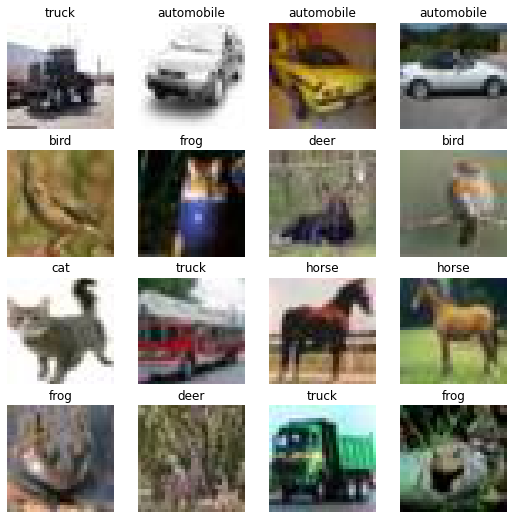

In [5]:
import torchvision
import modular.utils as utils
import torchvision.transforms as transforms

prev_dataset = torchvision.datasets.ImageFolder(root='data/train',transform=transforms.ToTensor())
utils.show_grid_preview(prev_dataset)

In [16]:
import modular.models as models
amlresnet50 = models.AMLResnet50(10)
amlresnet50.transforms

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [17]:
import modular.datasets as datasets

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=amlresnet50.transforms,
                                           batch_size=32,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                              transformer=amlresnet50.transforms,
                                              batch_size=32,
                                              suffle=False)

train_dataloader, validate_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fa500237c10>,
 <torch.utils.data.dataloader.DataLoader at 0x7fa500237640>)

In [14]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## AML Resnet50

In [18]:
from torchinfo import summary

batch_size = 16
img_size = 256
summary(model=amlresnet50, 
        input_size=(32, 3, img_size, img_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
AMLResnet50 (AMLResnet50)                     [32, 3, 256, 256]    [32, 10]             --                   Partial
├─ResNet (net)                                [32, 3, 256, 256]    [32, 2048]           --                   False
│    └─Conv2d (conv1)                         [32, 3, 256, 256]    [32, 64, 128, 128]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 128, 128]   [32, 64, 128, 128]   (128)                False
│    └─ReLU (relu)                            [32, 64, 128, 128]   [32, 64, 128, 128]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 128, 128]   [32, 64, 64, 64]     --                   --
│    └─Sequential (layer1)                    [32, 64, 64, 64]     [32, 256, 64, 64]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 64, 64]     [32, 256, 64,

In [22]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path

# Model
amlresnet50 = models.AMLResnet50(out_dim=10)

# Optimizer
optimizer = torch.optim.Adam(params=amlresnet50.parameters(),
                             lr=0.001)

# Criterion
loss = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 10

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('trained/amlresnet50.pth')

# Data augmentation
train_transform, valid_transform = amlresnet50.transforms, amlresnet50.transforms

batch_size=500

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transform,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=valid_transform,
                                           batch_size=batch_size,
                                           suffle=False)

In [20]:
! mkdir trained 

In [ ]:
from modular.engine import train

results = train(model=amlresnet50,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                loss_fn=loss,
                epochs=epochs,
                device=device,
                save_as=save_as)


results

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.6174 | train_acc: 0.4827 | test_loss: 1.3250 | test_acc: 0.5577


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 1.2501 | train_acc: 0.5819 | test_loss: 1.1948 | test_acc: 0.5985


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 1.1544 | train_acc: 0.6077 | test_loss: 1.1372 | test_acc: 0.6128


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4 | train_loss: 1.1017 | train_acc: 0.6244 | test_loss: 1.0975 | test_acc: 0.6232


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5 | train_loss: 1.0629 | train_acc: 0.6370 | test_loss: 1.0760 | test_acc: 0.6314


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 6 | train_loss: 1.0378 | train_acc: 0.6435 | test_loss: 1.0544 | test_acc: 0.6356


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 7 | train_loss: 1.0155 | train_acc: 0.6528 | test_loss: 1.0442 | test_acc: 0.6390


0it [00:00, ?it/s]

#Load

In [17]:
PATH = "/content/drive/MyDrive/AML/amlresnet50.pth"

In [33]:
# Model class must be defined somewhere
model = torch.load(PATH)

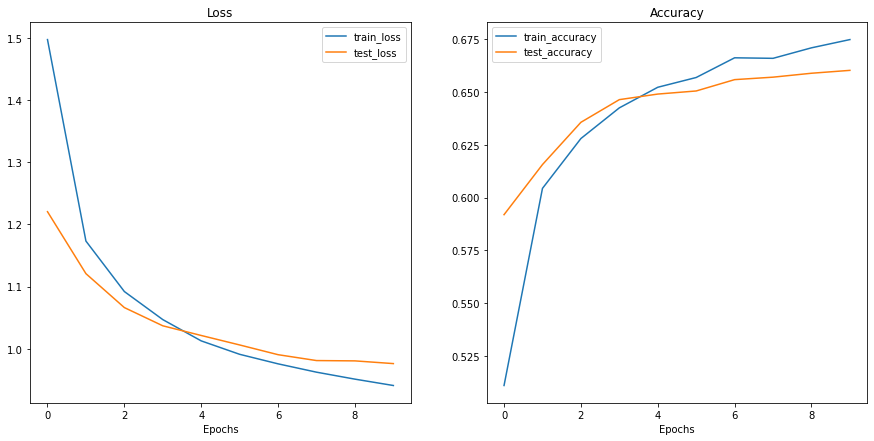

In [36]:
import modular.utils as utils
utils.plot_loss_curves(model)

In [ ]:
from google.colab import files
#files.download('/content/data/amlresnet50.pth')
files.download('/content/trained/amlresnet50.pth')